In [1]:
import pandas as pd
import numpy as np
import sys
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('/raven/u/ajagadish/vanilla-llama/categorisation/')
sys.path.append('/raven/u/ajagadish/vanilla-llama/categorisation/data')
sys.path.append('/raven/u/ajagadish/vanilla-llama/categorisation/rl2')

In [2]:
FONTSIZE=20

### transformer model

In [3]:
from envs import CategorisationTask, SyntheticCategorisationTask
max_steps=70
num_dims=2
env = SyntheticCategorisationTask(num_dims=num_dims, max_steps=max_steps, batch_size=32, noise=0., shuffle_trials=False)

In [3]:
## decoder-based model
from rl2.model import TransformerDecoder
model = TransformerDecoder(num_input=num_dims, num_output=1, num_hidden=128, num_layers=1, d_model=256, num_head=2)#4)

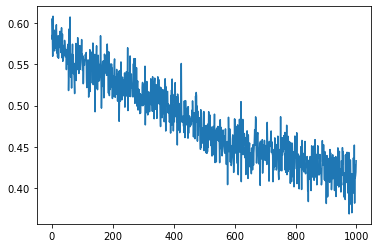

In [14]:
plt.plot(losses)

In [32]:
## evaluate on already trained model
model = torch.load('/raven/u/ajagadish/vanilla-llama/categorisation/trained_models/env=transformer_metalearning_synthetic_model=transformer_num_episodes500000_num_hidden=2048_lr0.0003_num_layers=6_d_model=512_num_head=8_noise0.0_shuffleFalse_run=0_synthetic.pt')[1]

In [39]:
## setup enviroment
eval_batch_size = 100
num_dims=3
env = SyntheticCategorisationTask(num_dims=num_dims, max_steps=max_steps, batch_size=eval_batch_size, noise=0.5, shuffle_trials=False)
packed_inputs, sequence_lengths, targets = env.sample_batch()

In [40]:
# evaluate model
model.beta = 1. #0.1
model.eval()
model_choices = model(packed_inputs, sequence_lengths)
pred_model_chioces = torch.distributions.Binomial(probs=model_choices).sample()

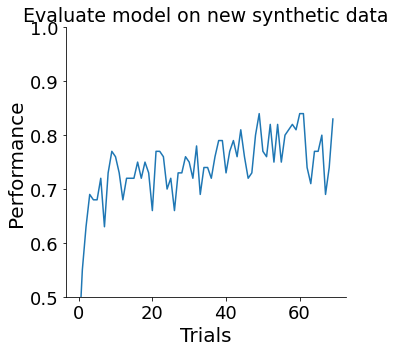

In [41]:
f, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot((pred_model_chioces.squeeze()==targets).sum(0)/eval_batch_size)
ax.set_title('Evaluate model on new synthetic data', fontsize=FONTSIZE-1)
ax.set_xlabel('Trials', fontsize=FONTSIZE)
ax.set_ylabel('Performance', fontsize=FONTSIZE)
ax.set_ylim([0.5, 1.])
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
sns.despine()
f.tight_layout()
plt.show()

Text(0.5, 1.0, 'Transformer Predictions')

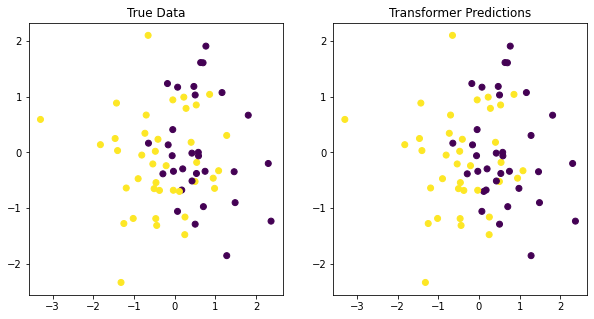

In [20]:
# compare example scatter plots
batch_idx = torch.randint(eval_batch_size, (1,))
fig, axs = plt.subplots(1, 2,  figsize=(10,5))
axs[0].scatter(packed_inputs[batch_idx, :, 0], packed_inputs[batch_idx,:, 1], c=targets[batch_idx]);
axs[0].set_title('True Data')
axs[1].scatter(packed_inputs[batch_idx, :, 0], packed_inputs[batch_idx,:, 1], c=pred_model_chioces[batch_idx].detach().numpy());
axs[1].set_title('Transformer Predictions')

#### test model on human categorisation task

In [ ]:
from plots import evaluate_nosofsky1988, evaluate_levering2020, evaluate_nosofsky1994
env_model_name = 'transformer_metalearning_synthetic_model=transformer_num_episodes500000_num_hidden=2048_lr0.0003_num_layers=6_d_model=512_num_head=8'
evaluate_nosofsky1994(env_name=env_model_name, tasks=np.arange(1,7), beta=1., noises=[0.0], shuffles=[False], shuffle_evals=[False], experiment='shepard_categorisation', num_runs=50, num_eval_tasks=64, synthetic=True)

In [ ]:
evaluate_levering2020(env_name=env_model_name, noises=[0.0], beta=1., shuffles=[False], num_runs=50, num_eval_tasks=64, num_trials=150, synthetic=True)

In [ ]:
evaluate_nosofsky1988(env_name=env_model_name, experiment=2, beta=1., noises=[0.0], shuffles=[False], num_runs=50, num_blocks=1, num_eval_tasks=64, synthetic=True)

### auto-regression task

In [54]:
import numpy as np
import torch

# Generate synthetic temperature data (for demonstration purposes)
days = np.arange(0, 365)
# A simple sinusoidal pattern to mimic seasonal changes
temperatures = 1 * np.sin(2 * np.pi * days / 365)

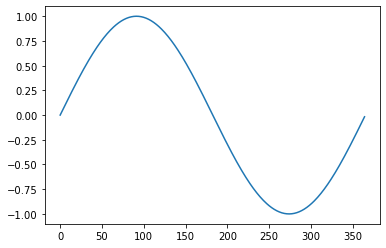

In [55]:
plt.plot(days, temperatures);

In [56]:
# The task is to predict temperature of the next day using the temperatures of the last `seq_length` days.
seq_length = 10
data = []
labels = []

for i in range(len(temperatures) - seq_length):
    data.append(temperatures[i:i+seq_length])
    labels.append(temperatures[i+seq_length])

data = torch.tensor(data).float()
labels = torch.tensor(labels).float()


In [57]:
import torch.nn as nn

class TempPredictor(nn.Module):
    def __init__(self, d_model, nhead, num_layers, seq_length):
        super(TempPredictor, self).__init__()
        self.embedding = nn.Linear(1, d_model)  # We use a linear layer as a simple "embedding" for temperatures
        self.pos_encoder = nn.Embedding(seq_length, d_model)  # Positional encoding
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model, nhead),
            num_layers
        )
        self.fc = nn.Linear(d_model, 1)
        self.d_model = d_model

    def forward(self, x):
        positions = torch.arange(0, x.size(1)).unsqueeze(0).to(x.device)
        x = self.embedding(x)
        x += self.pos_encoder(positions)
        x = self.transformer_decoder(x, x)
        return self.fc(x[:, -1])  # Predict only the last position (next day)

model = TempPredictor(d_model=512, nhead=2, num_layers=1, seq_length=seq_length)


In [58]:
# Hyperparameters & Utilities
learning_rate = 0.001
epochs = 50
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    predictions = model(data.unsqueeze(-1))
    loss = loss_function(predictions.squeeze(), labels)
    
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [10/50], Loss: 0.5653
Epoch [20/50], Loss: 0.6611
Epoch [30/50], Loss: 0.5114
Epoch [40/50], Loss: 0.4983
Epoch [50/50], Loss: 0.4928


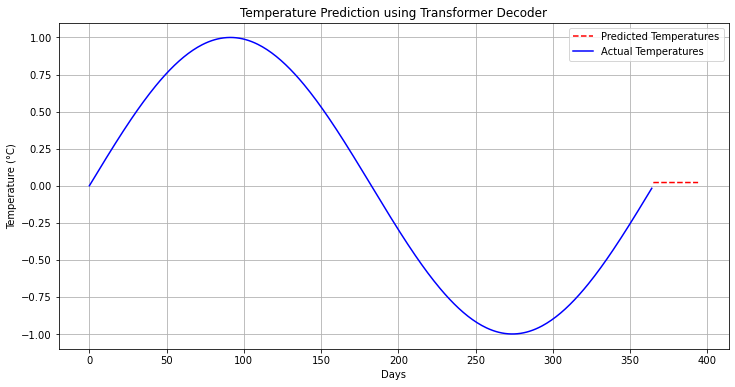

In [62]:
model.eval()  # Set the model to evaluation mode

# Start with the last `seq_length` days from our data
input_seq = data[-1].unsqueeze(0).unsqueeze(-1)  # Shape: (1, seq_length, 1)
predicted_temps = []

# Predict temperatures for the next 30 days
for _ in range(30):
    with torch.no_grad():
        next_temp = model(input_seq)  # Predict the temperature for the next day
    predicted_temps.append(next_temp.item())
    
    # Prepare the input for the next prediction
    new_seq = torch.roll(input_seq, shifts=-1, dims=1)
    new_seq[0, -1, 0] = next_temp
    input_seq = new_seq
    #print(new_seq)

# Let's visualize the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(len(temperatures), len(temperatures)+30), predicted_temps, label="Predicted Temperatures", color="red", linestyle="--")
plt.plot(temperatures, label="Actual Temperatures", color="blue")

plt.legend()
plt.title("Temperature Prediction using Transformer Decoder")
plt.xlabel("Days")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.show()

### eval model per task per trial

In [3]:
import torch
from rl2.envs import CategorisationTask
import argparse
from baseline_classifiers import SVMModel, LogisticRegressionModel
import matplotlib.pyplot as plt
from rl2.evaluate import evaluate_against_baselines, evaluate
import seaborn as sns

In [4]:
env_name = '/raven/u/ajagadish/vanilla-llama/categorisation/data/llama_generated_tasks_params65B_dim3_data8_tasks14500.csv'
model_path = '../trained_models/env=llama_generated_tasks_params65B_dim3_data8_tasks14500_num_episodes1000000_num_hidden=128_lr0.0003_run=0.pt'
mode = 'val'
return_all = True

#### using predict instead of predict_prob and choosing greedily on that

In [12]:
# load environment
env = CategorisationTask(data=env_name, mode=mode)

# load models
_, _, _, done, info = env.reset()
inputs, targets = info['inputs'], info['targets']
baseline_model_choices, true_choices, tasks = [], [], []
num_tasks =targets.shape[0]

num_trials = env.max_steps

# loop over dataset making predictions for next trial using model trained on all previous trials
for task in range(num_tasks):
    trial = env.max_steps-1 # only evaluate on last trial; not possible to evaluate on first trial as it will only have one class
    # loop over trials
    while trial < num_trials:
        trial_inputs = inputs[task, :trial]
        trial_targets = targets[task, :trial]
        #print(trial, trial_inputs, trial_targets, trial_inputs.shape)
        try:
            lr_model = LogisticRegressionModel(trial_inputs, trial_targets)
            svm_model = SVMModel(trial_inputs, trial_targets)
            lr_model_choice = lr_model.predict(inputs[task, trial:trial+1])
            svm_model_choice = svm_model.predict(inputs[task, trial:trial+1])
            lr_model_full_choice = LogisticRegressionModel(inputs[task], targets[task]).predict(inputs[task, trial:trial+1])
            svm_model_full_choice = SVMModel(inputs[task], targets[task]).predict(inputs[task, trial:trial+1])
            #print(lr_model.predict(inputs[task, trial:trial+1]), svm_model.predict(inputs[task, trial:trial+1]))
            #print(torch.tensor([lr_model_choice, svm_model_choice]))
            true_choice = targets[task, trial:trial+1]
            baseline_model_choices.append(torch.tensor([lr_model_choice, svm_model_choice, lr_model_full_choice, svm_model_full_choice, true_choice]))
            true_choices.append(true_choice)
            tasks.append(task)
        except:
            print('error')
        trial += 1

error
error
error
error
error
error
error


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


error
error
error
error


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


error
error
error
error


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [13]:
baseline_model_choices, true_choices = torch.stack(baseline_model_choices).squeeze(), torch.stack(true_choices).squeeze()

In [14]:
[(baseline_model_choices[:, model_id] == true_choices).sum()/len(tasks) for model_id in range(5)]

[tensor(0.4120), tensor(0.5120), tensor(0.7017), tensor(0.8940), tensor(1.)]

#### choosing choices greedily on predicted probs

In [15]:
a_, model_, true_ = evaluate_against_baselines(env_name, model_path, mode, return_all)

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error


In [16]:
a_

[tensor(0.4120), tensor(0.4410), tensor(0.6060)]

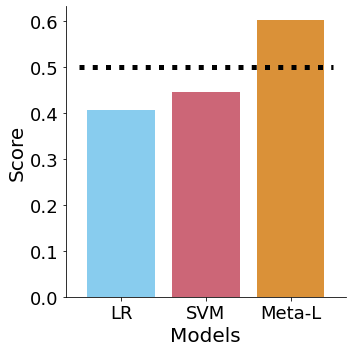

In [6]:
# performance = np.stack(performance)
# means = performance.mean(0)
# std_errors = performance.std(0)#/np.sqrt(num_tasks-1)
conditions = ['LR', 'SVM', 'Meta-L']
colors = [COLORS['lr'], COLORS['svm'], COLORS['metal']]
FIGSIZE=(5,5)
f, ax = plt.subplots(1, 1, figsize=FIGSIZE)
## bar plot
ax.bar(np.arange(0, len(conditions)), a_, color=colors, label=conditions)
# ax.errorbar(np.arange(0,len(conditions)), means, yerr=std_errors, color='k', lw=3, fmt='o') #linestyle='solid')

# ## plot individual points
# w = 0.5
ax.hlines(0.5, -0.5, 2.5, color='k', linestyles='dotted', lw=5)#, label='Random')
# for i in range(len(conditions)):
#     # distribute scatter randomly across whole width of bar
#     ax.scatter(i + np.random.random(performance.shape[0]) * w - w / 2, performance[:, i], color='k', alpha=.3, zorder=3)

## formatting    
# ax.set_ylim(ymin=0., ymax=1.)
plt.xticks(np.arange(0,len(conditions)))
plt.yticks(fontsize=FONTSIZE-2)
ax.set_xlabel('Models', fontsize=FONTSIZE)
ax.set_ylabel(f'Score', fontsize=FONTSIZE)#$a_{trials}$
ax.set_xticklabels(conditions, fontsize=FONTSIZE-2)#['', '']
sns.despine()
f.tight_layout()
plt.show()

(array([[808.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 362.],
        [751.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 419.],
        [579.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 591.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 3 BarContainer objects>)

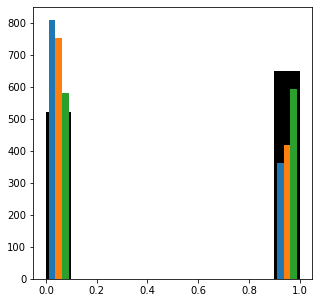

In [9]:
FIGSIZE=(5,5)
f, ax = plt.subplots(1, 1, figsize=FIGSIZE)
ax.hist(true_.numpy(), color='k')
ax.hist(model_.numpy())

### make synthetic dataset to test the model

### eval model per task

In [3]:
import torch
from rl2.envs import CategorisationTask
import argparse
from baseline_classifiers import SVMModel, LogisticRegressionModel
import matplotlib.pyplot as plt
from rl2.evaluate import evaluate
import seaborn as sns

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [21]:
env_name = '/raven/u/ajagadish/vanilla-llama/categorisation/data/llama_generated_tasks_params65B_dim3_data8_tasks14500.csv'
model_path = '../trained_models/env=llama_generated_tasks_params65B_dim3_data8_tasks14500_num_episodes1000000_num_hidden=128_lr0.0003_run=0.pt'
#env=llama_generated_tasks_params65B_dim3_data8_tasks14500_run=0.pt'
mode = 'val'
# load the eval data from environment
env = CategorisationTask(data=env_name, mode=mode)
_, _, _, _, info = env.reset()
performance = []

for ii in range(info['inputs'].shape[0]):
    
    # train svm classified on the same
    X = info['inputs'][ii]
    y = info['targets'][ii]
    try:
        lr = LogisticRegressionModel(X,y)
        svm = SVMModel(X,y)
    except:
        print('doesnt work')
    if ii == 0:
        _, model_choices, true_choices = evaluate(env_name=env_name, model_path=model_path, mode=mode, policy='greedy', return_all=True)
        ml2 = (model_choices.argmax(2)==true_choices).sum(0)/8
        
    performance.append([lr.score(X, y), svm.score(X, y), ml2[ii]])

doesnt work


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter wa

doesnt work
doesnt work
doesnt work


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [ ]:
COLORS = {'compositional':'#117733', 
          'noncompositional':'#96CAA7',
          'lr':'#88CCEE',#882255
          'svm':'#CC6677',
          'optimal': '#D6BF4D',
          'mean_tracker':'#882255', #332288
          'mean_tracker_compositional':'#882255', #AA4499',
          'rbf_nocontext_nomemory':'#44AA99', 
          'simple_grammar_constrained':'#44AA99',
          'simple_grammar_constrained_noncompositonal':'#EF9EBB',
          'rl2':'#E2C294', #'#0571D0', 
          'metal':'#DA9138', #"#D55E00", 
          }
FONTSIZE=20

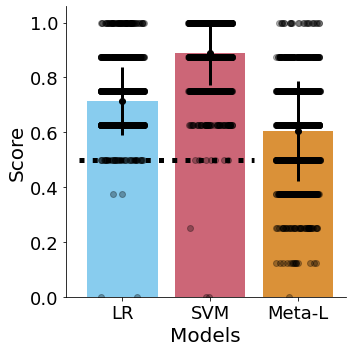

In [23]:
performance = np.stack(performance)
means = performance.mean(0)
std_errors = performance.std(0)#/np.sqrt(num_tasks-1)
conditions = ['LR', 'SVM', 'Meta-L']
colors = [COLORS['lr'], COLORS['svm'], COLORS['metal']]
FIGSIZE=(5,5)
f, ax = plt.subplots(1, 1, figsize=FIGSIZE)
## bar plot
ax.bar(np.arange(0, len(conditions)), means, color=colors, label=conditions)
ax.errorbar(np.arange(0,len(conditions)), means, yerr=std_errors, color='k', lw=3, fmt='o') #linestyle='solid')

## plot individual points
w = 0.5
ax.hlines(0.5, -0.5, 1.5, color='k', linestyles='dotted', lw=5)#, label='Random')
for i in range(len(conditions)):
    # distribute scatter randomly across whole width of bar
    ax.scatter(i + np.random.random(performance.shape[0]) * w - w / 2, performance[:, i], color='k', alpha=.3, zorder=3)

## formatting    
# ax.set_ylim(ymin=0., ymax=1.)
plt.xticks(np.arange(0,len(conditions)))
plt.yticks(fontsize=FONTSIZE-2)
ax.set_xlabel('Models', fontsize=FONTSIZE)
ax.set_ylabel(f'Score', fontsize=FONTSIZE)#$a_{trials}$
ax.set_xticklabels(conditions, fontsize=FONTSIZE-2)#['', '']
sns.despine()
f.tight_layout()
plt.show()

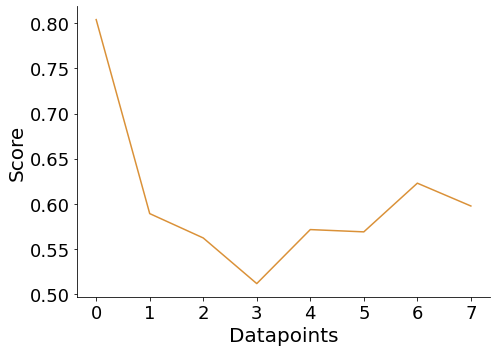

In [41]:

FIGSIZE=(7,5)
f, ax = plt.subplots(1, 1, figsize=FIGSIZE)

## plot individual points
ax.plot(np.arange(true_choices.shape[0]), (model_choices.argmax(2)==true_choices).sum(1)/true_choices.shape[1], c=COLORS['metal'])

## formatting    
# ax.set_ylim(ymin=0., ymax=1.)
plt.yticks(fontsize=FONTSIZE-2)
ax.set_xlabel('Datapoints', fontsize=FONTSIZE)
ax.set_ylabel(f'Score', fontsize=FONTSIZE)#$a_{trials}$
plt.xticks(fontsize=FONTSIZE-2)#['', '']
sns.despine()
f.tight_layout()
plt.show()

### check if performance of trained meta-learning model makes sesne

In [3]:
import torch
from rl2.envs import CategorisationTask
import argparse
from baseline_classifiers import SVMModel, LogisticRegressionModel
import matplotlib.pyplot as plt
from rl2.evaluate import evaluate
import seaborn as sns

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
env_name = '/raven/u/ajagadish/vanilla-llama/categorisation/data/llama_generated_tasks_params65B_dim3_data8_tasks14500.csv'
model_path = '../trained_models/env=llama_generated_tasks_params65B_dim3_data8_tasks14500_num_episodes1000000_num_hidden=128_lr0.0003_run=0.pt'
#env=llama_generated_tasks_params65B_dim3_data8_tasks14500_run=0.pt'
mode = 'val'
# load the eval data from environment
env = CategorisationTask(data=env_name, mode=mode)
_, _, _, _, info = env.reset()

# train svm classified on the same
X = info['inputs']
y = info['targets']
X = X.view(X.shape[0]*X.shape[1], X.shape[2])
y = y.view(y.shape[0]*y.shape[1])
performance = []
lr = LogisticRegressionModel(X,y)
svm = SVMModel(X,y)
ml2 = evaluate(env_name=env_name, model_path=model_path, mode=mode, policy='greedy')
performance.append([lr.score(X, y), svm.score(X, y), ml2])

Text(0, 0.5, 'Score')

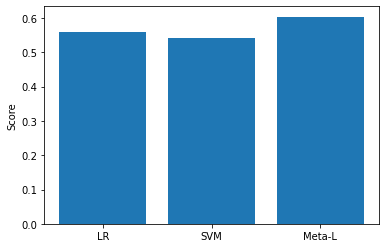

In [5]:
# plot its performance against the meta-learning models performance
plt.bar(['LR', 'SVM', 'Meta-L'], performance[0])
plt.ylabel('Score')

### evaluate trained model

In [2]:
from rl2.evaluate import evaluate

In [36]:
evaluate(env_name='/raven/u/ajagadish/vanilla-llama/categorisation/data/llama_generated_tasks_params65B_dim3_data8_tasks14500.csv', model_path='../trained_models/env=llama_generated_tasks_params65B_dim3_data8_tasks14500_run=0.pt', mode='val', policy='greedy')

tensor(0.5575)

In [10]:
from rl2.rl2 import RL2
from envs import CategorisationTask
import torch

In [12]:
env_name = '/raven/u/ajagadish/vanilla-llama/categorisation/data/llama_generated_tasks_params65B_dim3_data8_tasks14500.csv'# if args.env_name is None else args.env_name
env = CategorisationTask(data=env_name, mode='test')
policy = 'greedy'

model = torch.load('./test')[1]
model.eval()

inputs, targets, done, info = env.reset()
hx, cx = model.initial_states(env.batch_size)
model_choices = []
true_choices = []
while not done:
    model_choice, hx, cx = model(inputs.unsqueeze(1).float(), hx, cx)
    true_choice = targets
    model_choices.append(model_choice)
    true_choices.append(true_choice)
    inputs, targets, done, info = env.step() 
model_choices = torch.stack(model_choices).squeeze()
true_choices = torch.stack(true_choices)

true_choices.shape, model_choices.shape

#predictions = model_choices.squeeze().argmax(2).reshape(-1)
predictions = model_choices.argmax(2).reshape(-1) if policy=='greedy' else \
          model_choices.view(model_choices.shape[0]*model_choices.shape[1], model_choices.shape[2]).multinomial(1).reshape(-1)
accuracy = (true_choices.reshape(-1)==predictions).sum()/(len(predictions))
print(accuracy)

tensor(0.5623)


###  test trainer 

In [2]:
from rl2.train import run
import matplotlib.pyplot as plt

In [3]:
env_name = '/raven/u/ajagadish/vanilla-llama/categorisation/data/llama_generated_tasks_params65B_dim3_data8_tasks14500.csv'# if args.env_name is None else args.env_name
num_episodes = 10
print_every = 1
save_every = 1
num_hidden = 128
save_dir = 'test'
device = 'cpu'
lr = 0.001
batch_size= 32

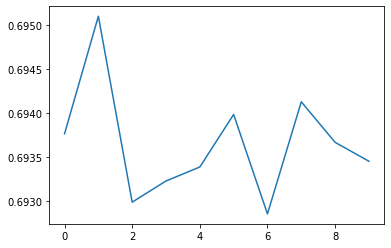

In [6]:
plt.plot(loss[0])

### test model 

In [5]:
from model import RL2
import torch

In [6]:
model = RL2(3, 2, 10, 1)
hx, cx = torch.randn(1, 32, 10), torch.randn(1, 32, 10)

In [7]:
model_choice, hx, cx = model(torch.zeros(32, 1, 3), hx, cx)

In [8]:
model_choice

tensor([[[0.6750, 0.3250]],

        [[0.5648, 0.4352]],

        [[0.6343, 0.3657]],

        [[0.5977, 0.4023]],

        [[0.4539, 0.5461]],

        [[0.5511, 0.4489]],

        [[0.5057, 0.4943]],

        [[0.6200, 0.3800]],

        [[0.5727, 0.4273]],

        [[0.5265, 0.4735]],

        [[0.4817, 0.5183]],

        [[0.5613, 0.4387]],

        [[0.5925, 0.4075]],

        [[0.6215, 0.3785]],

        [[0.6662, 0.3338]],

        [[0.5796, 0.4204]],

        [[0.6932, 0.3068]],

        [[0.5999, 0.4001]],

        [[0.6275, 0.3725]],

        [[0.6274, 0.3726]],

        [[0.6589, 0.3411]],

        [[0.5171, 0.4829]],

        [[0.4670, 0.5330]],

        [[0.5960, 0.4040]],

        [[0.6114, 0.3886]],

        [[0.6740, 0.3260]],

        [[0.4488, 0.5512]],

        [[0.6199, 0.3801]],

        [[0.6522, 0.3478]],

        [[0.5969, 0.4031]],

        [[0.6030, 0.3970]],

        [[0.5364, 0.4636]]], grad_fn=<SoftmaxBackward0>)

In [ ]:
%debug

### test env

In [2]:
from rl2.envs import CategorisationTask

In [3]:
cat = CategorisationTask(data='/raven/u/ajagadish/vanilla-llama/categorisation/data/llama_generated_tasks_params65B_dim3_data8_tasks14500.csv')
cat.reset()
inputs, targets, prev_targets, done, info = cat.step()

In [4]:
inputs, targets, prev_targets,

(tensor([[ 3.0338e-01, -1.9097e+00,  2.8701e-01],
         [-1.2476e-01,  6.0549e-02, -1.0633e-01],
         [-7.9657e-01, -1.0489e-01,  2.8228e+00],
         [-7.0891e-01,  6.9505e-02,  8.0839e-01],
         [-6.4090e-01, -1.5185e+00,  1.1352e-01],
         [-2.2882e-01, -6.8803e-01, -1.2855e+00],
         [-1.8645e-01,  3.2430e-01, -1.0423e+00],
         [-8.7049e-01,  8.3363e-01, -9.6481e-02],
         [-5.1853e-01,  1.2879e+00,  1.5586e+00],
         [-4.0183e-01, -1.3265e+00, -4.1905e-01],
         [-9.8021e-01,  9.9979e-01, -4.0070e-01],
         [ 6.9747e-01,  9.5135e-01,  3.2216e-01],
         [ 8.6813e-01, -1.7805e-02, -1.5133e+00],
         [ 1.5858e-01, -8.9302e-01,  4.2155e-01],
         [ 9.7858e-01, -5.8662e-02,  2.5402e+00],
         [ 8.9707e-01, -2.0244e+00,  1.2570e+00],
         [-9.8806e-01, -1.2278e+00, -9.1845e-01],
         [-3.4932e-01,  7.9227e-01, -1.0020e-01],
         [ 9.4218e-01,  4.2162e-01, -1.6447e+00],
         [-1.1035e+00,  2.9597e+00, -2.4014e-01],


### test pooler

In [11]:
from utils import return_generated_task, pool_generated_tasks, parse_generated_tasks

In [12]:
parse_generated_tasks('/raven/u/ajagadish/vanilla-llama/categorisation/data',\
                      'llama_generated_tasks_params65B_dim3_data96_tasks10_run0_procid999',\
                      96)

dataset did not have 96 datapoints but instead had 6 datapoints
dataset did not have 96 datapoints but instead had 72 datapoints
dataset did not have 96 datapoints but instead had 92 datapoints
dataset did not have 96 datapoints but instead had 29 datapoints
dataset did not have 96 datapoints but instead had 84 datapoints
dataset did not have 96 datapoints but instead had 82 datapoints
no datasets were successfully parsed


In [13]:
num_datapoints_per_task = np.array([6, 72, 92, 29, 84, 82])
#1000 [47, 38, 49, 40, 55, 28, 10, 47, 34])#

In [14]:
num_datapoints_per_task.mean()

60.833333333333336

In [60]:
path ='/raven/u/ajagadish/vanilla-llama/categorisation/data/'
models = ['65B']
dims = [3]
data = [8]
tasks = [1000, 2000, 500, 1500]
runs = [0] #{1000: 0, 2000: 0}
proc_ids = {1000: range(0, 8), 2000: range(0,2), 500: range(0,2), 1500: range(0,1)}

In [61]:
data = pool_generated_tasks(path, models, dims, data, tasks, runs, proc_ids)

/raven/u/ajagadish/vanilla-llama/categorisation/utils.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['task_id'] = np.int64(np.arange(len(df))/num_data) #+ 1


In [62]:
data

,Unnamed: 0,input,target,task_id
0,0,"[0.0, 0.3333, 0.4428]",A,0
1,1,"[0.2123, 0.9156, 0.1037]",A,0
2,2,"[0.5652, 0.528, 0.031]",A,0
3,3,"[0.0242, 0.0375, 0.979]",A,0
4,4,"[0.5609, 0.9265, 0.8422]",B,0
...,...,...,...,...
95283,9659,"[0.5, 0.6, 0.5]",A,11851
95284,9660,"[0.6, 0.4, 0.5]",B,11851
95285,9661,"[0.7, 0.3, 0.6]",A,11851
95286,9662,"[0.4, 0.7, 0.2]",B,11851


In [45]:
data['task_id'] = np.int64(np.arange(len(data))/8)+1

In [62]:
num_data_points = 8
num_tasks = 3
tasks = [10, 12, 35]
data[data.task_id.isin(tasks)].input.values.reshape(num_tasks, num_data_points)
data[data.task_id.isin(tasks)].target.values.reshape(num_tasks, num_data_points)

array([['B', 'A', 'A', 'A', 'B', 'B', 'B', 'B'],
       ['A', 'A', 'B', 'B', 'B', 'A', 'A', 'A'],
       ['A', 'A', 'A', 'A', 'B', 'A', 'A', 'B']], dtype=object)

In [ ]:
df['Index'] = data.index % 8

In [30]:
xx = (data.index/8)#.dtype('int')

In [33]:
np.int64(xx)

array([    0,     0,     0, ..., 11910, 11910, 11910])